# Imports

In [2]:
import glob
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter

import cv2
from concurrent import futures
import threading

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data import

In [3]:
#getting the total number of images in the training set

base_dir = '../input'

train_dir = os.path.join(base_dir, 'train', 'train')

type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(base_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(base_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(base_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = type1_files + added_type1_files
type2_files = type2_files + added_type2_files
type3_files = type3_files + added_type3_files


print('Number of images in a train set of type 1: ', len(type1_files))
print('Number of images in a train set of type 2: ', len(type2_files))
print('Number of images in a train set of type 3: ', len(type3_files))
print('Total number of images in a train set: ', sum([len(type1_files), len(type2_files), len(type3_files)]))

Number of images in a train set of type 1:  1191
Number of images in a train set of type 2:  3567
Number of images in a train set of type 3:  1976
Total number of images in a train set:  6734


In [4]:
#Building a dataframe mapping images and Cancer type

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
})

files_df

,filename,label
0,../input/additional_Type_1_v2/Type_1/6241.jpg,Type_1
1,../input/additional_Type_1_v2/Type_1/623.jpg,Type_1
2,../input/additional_Type_1_v2/Type_1/2193.jpg,Type_1
3,../input/additional_Type_1_v2/Type_1/2008.jpg,Type_1
4,../input/additional_Type_1_v2/Type_1/5982.jpg,Type_1
...,...,...
6729,../input/additional_Type_3_v2/Type_3/5005.jpg,Type_3
6730,../input/additional_Type_3_v2/Type_3/4463.jpg,Type_3
6731,../input/additional_Type_3_v2/Type_3/5303.jpg,Type_3
6732,../input/additional_Type_3_v2/Type_3/6119.jpg,Type_3


In [5]:
#Shuffle data

random_state = 42

files_df = files_df.sample(frac=1, random_state=random_state)

files_df

,filename,label
381,../input/additional_Type_1_v2/Type_1/1518.jpg,Type_1
4696,../input/additional_Type_2_v2/Type_2/1698.jpg,Type_2
5577,../input/additional_Type_3_v2/Type_3/4435.jpg,Type_3
2018,../input/additional_Type_2_v2/Type_2/4915.jpg,Type_2
2185,../input/additional_Type_2_v2/Type_2/1335.jpg,Type_2
...,...,...
3772,../input/additional_Type_2_v2/Type_2/1182.jpg,Type_2
5191,../input/additional_Type_3_v2/Type_3/1912.jpg,Type_3
5226,../input/additional_Type_3_v2/Type_3/5572.jpg,Type_3
5390,../input/additional_Type_3_v2/Type_3/5508.jpg,Type_3


# Data exploration

In [6]:
files_df.describe()

,filename,label
count,6734,6734
unique,6734,3
top,../input/additional_Type_1_v2/Type_1/1518.jpg,Type_2
freq,1,3567


In [7]:
#Check for duplicates
len(files_df[files_df.duplicated()])

0

In [8]:
#Get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type_2,3567
Type_3,1976
Type_1,1191


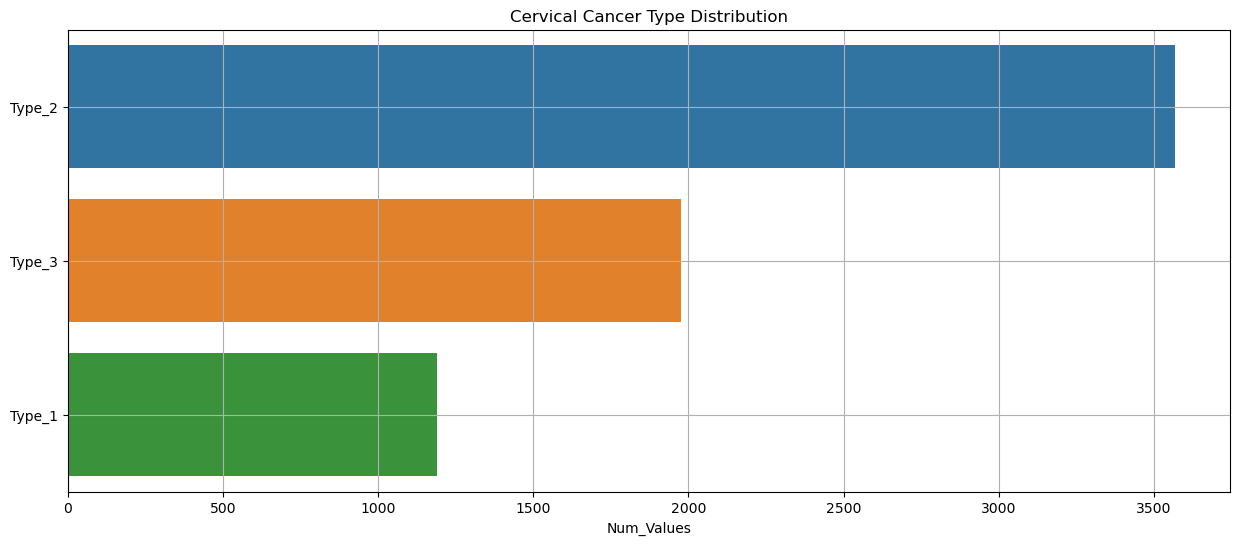

In [9]:
#Display barplot of type count
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Cervical Cancer Type Distribution')
plt.grid(True)
plt.show()

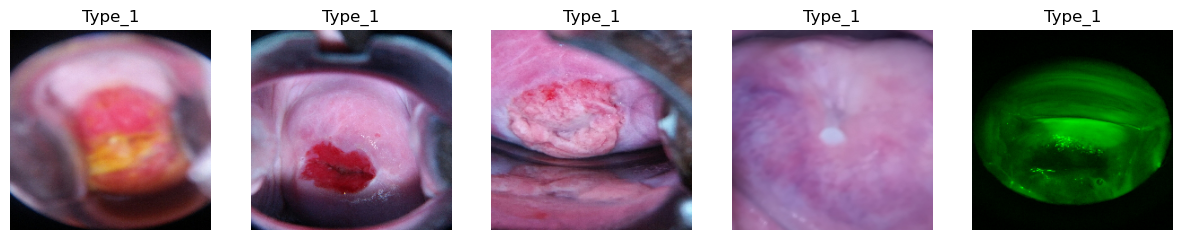

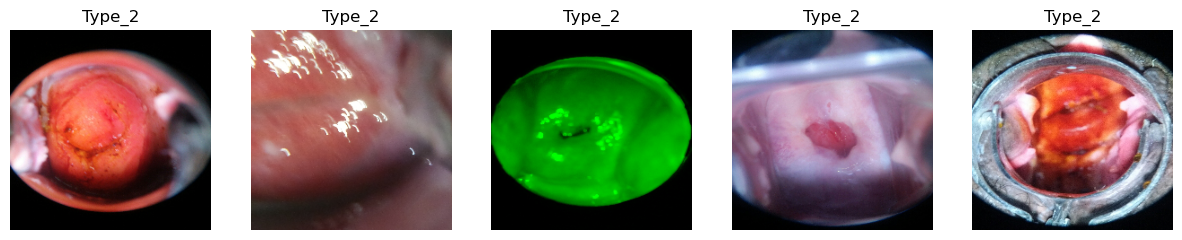

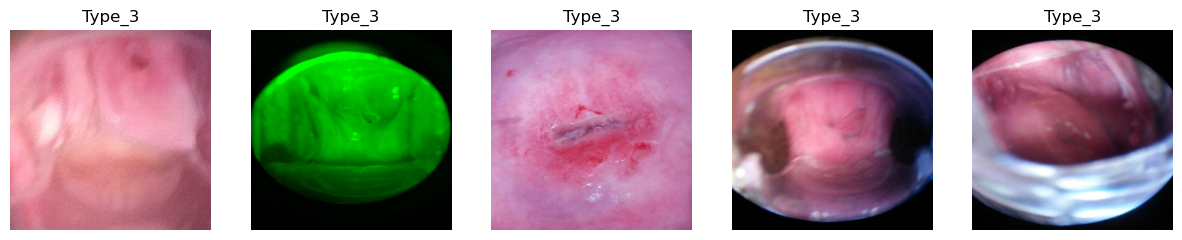

In [10]:
#Display sample images of types
for label in ('Type_1', 'Type_2', 'Type_3'):
    filepaths = files_df[files_df['label']==label]['filename'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data propocessing

In [11]:
#Split training,val and test set : 70:15:15

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, 
                                                                      random_state=random_state)

test_files, val_files, test_labels, val_labels = train_test_split(test_files,
                                                                  test_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=random_state)


print('Number of images in train set: ', train_files.shape)
print('Number of images in validation set: ', val_files.shape)
print('Number of images in test set: ', test_files.shape, '\n')

print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Number of images in train set:  (4713,)
Number of images in validation set:  (1011,)
Number of images in test set:  (1010,) 

Train: Counter({'Type_2': 2532, 'Type_3': 1339, 'Type_1': 842}) 
Val: Counter({'Type_2': 529, 'Type_3': 321, 'Type_1': 161}) 
Test: Counter({'Type_2': 506, 'Type_3': 316, 'Type_1': 188})


In [12]:
def load_images(files, labels):
    features = []
    correct_labels = []
    bad_images = 0
    
    for i in range(len(files)):
        try:
            img = cv2.imread(files[i])
            resized_img = cv2.resize(img, (160, 160))
            
            features.append(np.array(resized_img))
            correct_labels.append(labels[i])
                   
        except Exception as e:
            bad_images+=1
            print('Encoutered bad image')
    print('Bad images ecountered:', bad_images)
    return np.array(features), np.array(correct_labels)

In [13]:
#Load training and evaluation data
train_features, train_labels = load_images(train_files, train_labels)
print('Train images loaded')
val_features, val_labels = load_images(val_files, val_labels)
print('Validation images loaded')
test_features, test_labels = load_images(test_files, test_labels)
print('test images loaded')

Premature end of JPEG file


Encoutered bad image
Encoutered bad image
Bad images ecountered: 2
Train images loaded
Bad images ecountered: 0
Validation images loaded


Premature end of JPEG file


Encoutered bad image
Bad images ecountered: 1
test images loaded


In [14]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels) 

(4711, 4711, 1011, 1011, 1009, 1009)

In [15]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 20
INPUT_SHAPE = (160, 160, 3)

In [16]:
#encode train+val sets text categories with labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = tf.keras.utils.to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = tf.keras.utils.to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [1 1 1 2 1 0]
['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [17]:

le = LabelEncoder()
le.fit(test_labels)

test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = tf.keras.utils.to_categorical(test_labels_enc, num_classes=NUM_CLASSES)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [2 2 1 1 1 0]
['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

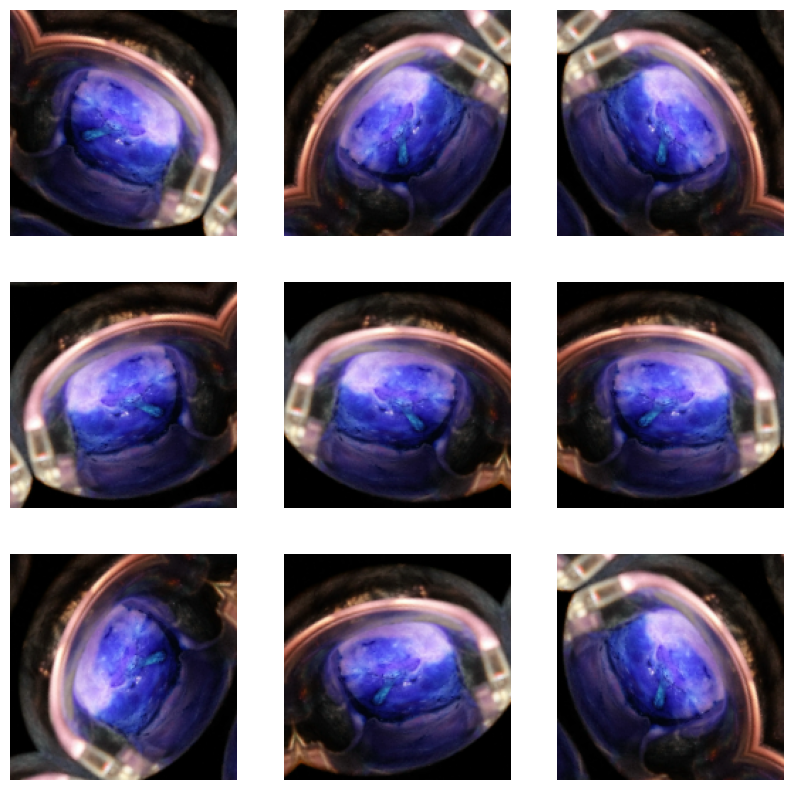

In [19]:
plt.figure(figsize=(10, 10))
first_image = train_features[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
        

# MobileNet V2 pre-trained

In [20]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)

#rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
x = preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
#compile the model
learning_rate=1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
history = model.fit(x=train_features, 
                    y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_features, val_labels_1hotenc),
                    verbose = 1)

Epoch 1/20
148/148 [==============================] - 14s 36ms/step - loss: 1.3100 - accuracy: 0.4252 - val_loss: 1.1408 - val_accuracy: 0.4441
Epoch 2/20
148/148 [==============================] - 3s 23ms/step - loss: 1.1881 - accuracy: 0.4627 - val_loss: 1.0787 - val_accuracy: 0.4629
Epoch 3/20
148/148 [==============================] - 4s 25ms/step - loss: 1.1236 - accuracy: 0.4683 - val_loss: 1.0445 - val_accuracy: 0.4787
Epoch 4/20
148/148 [==============================] - 3s 22ms/step - loss: 1.1013 - accuracy: 0.4855 - val_loss: 1.0236 - val_accuracy: 0.4886
Epoch 5/20
148/148 [==============================] - 3s 22ms/step - loss: 1.0799 - accuracy: 0.4931 - val_loss: 1.0070 - val_accuracy: 0.4857
Epoch 6/20
148/148 [==============================] - 3s 23ms/step - loss: 1.0682 - accuracy: 0.4967 - val_loss: 0.9949 - val_accuracy: 0.5074
Epoch 7/20
148/148 [==============================] - 3s 23ms/step - loss: 1.0398 - accuracy: 0.5024 - val_loss: 0.9904 - val_accuracy: 0.516

In [25]:
def learning_performance_chart(title='Learning Perfomance', history=history):
    #plots a chart showing the change in accuracy and loss function over epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    

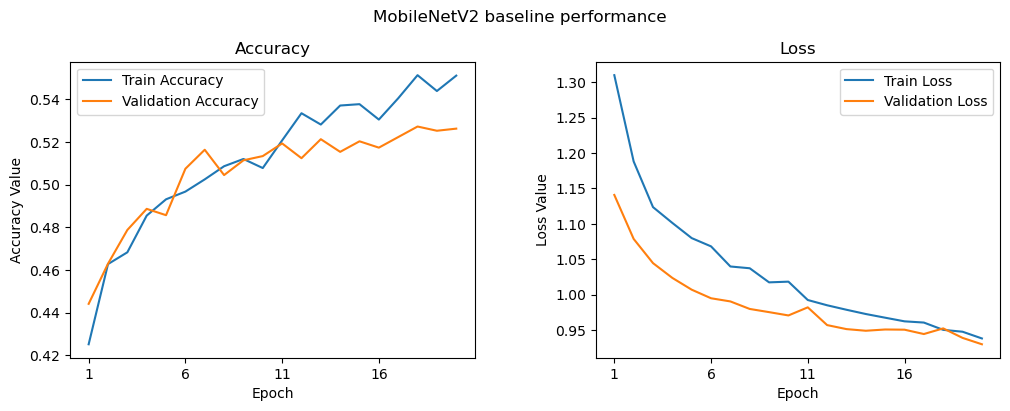

In [26]:
learning_performance_chart(title='MobileNetV2 baseline performance', history=history)

In [27]:
print('MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

MobileNetV2 performance on the test set:
32/32 [==============================] - 1s 26ms/step - loss: 0.9545 - accuracy: 0.5372


In [28]:
#keep track of the models performance
performance_df = pd.DataFrame(columns=['model','test set accuracy'])

def record_performance(df, model_name, test_accuracy):
    return df.append(
        {'model':model_name, 'test set accuracy':test_accuracy},
        ignore_index=True)

performance_df = record_performance(performance_df, 'MobileNetV2 base', results[1])
performance_df

/tmp/ipykernel_28/3909242234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


,model,test set accuracy
0,MobileNetV2 base,0.537166


# Fine tuning

In [29]:
tuning_model_1 = base_model
tuning_model_1.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(tuning_model_1.layers))

Number of layers in the base model:  154


## Fine tune at 120 layer

In [31]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuning_model_1.layers[:fine_tune_at]:
    layer.trainable = False

In [32]:
# Compile the model
# Use smaller learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [33]:
len(model.trainable_variables)

38

In [34]:
# Train the model some more

fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(x= train_features,
                         y=train_labels_1hotenc, 
                         batch_size=BATCH_SIZE,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_features, val_labels_1hotenc),
                         verbose=1)

Epoch 20/40
148/148 [==============================] - 16s 34ms/step - loss: 0.9361 - accuracy: 0.5436 - val_loss: 0.9175 - val_accuracy: 0.5302
Epoch 21/40
148/148 [==============================] - 4s 27ms/step - loss: 0.9037 - accuracy: 0.5589 - val_loss: 0.9263 - val_accuracy: 0.5371
Epoch 22/40
148/148 [==============================] - 4s 27ms/step - loss: 0.8879 - accuracy: 0.5740 - val_loss: 0.8967 - val_accuracy: 0.5331
Epoch 23/40
148/148 [==============================] - 4s 29ms/step - loss: 0.8692 - accuracy: 0.5835 - val_loss: 0.8909 - val_accuracy: 0.5381
Epoch 24/40
148/148 [==============================] - 4s 28ms/step - loss: 0.8491 - accuracy: 0.5994 - val_loss: 0.9107 - val_accuracy: 0.5549
Epoch 25/40
148/148 [==============================] - 4s 27ms/step - loss: 0.8391 - accuracy: 0.6054 - val_loss: 0.8879 - val_accuracy: 0.5509
Epoch 26/40
148/148 [==============================] - 4s 26ms/step - loss: 0.8286 - accuracy: 0.6092 - val_loss: 0.8826 - val_accuracy

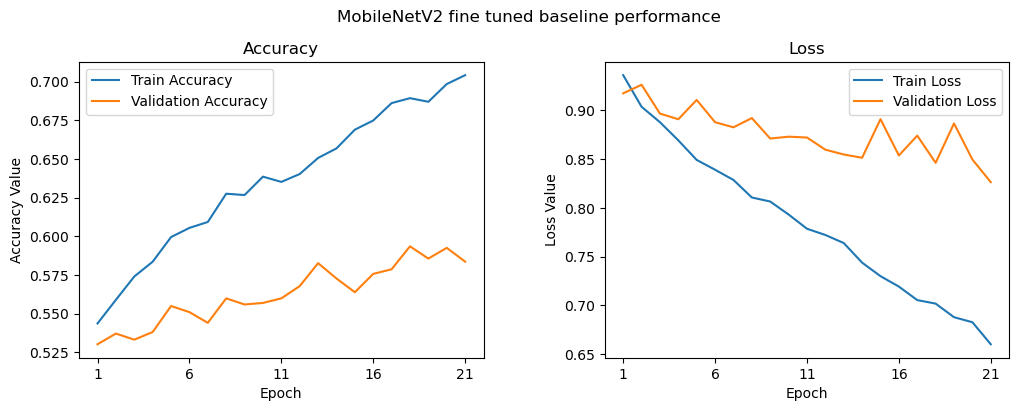

In [35]:
learning_performance_chart(title='MobileNetV2 fine tuned baseline performance', history=history_fine)

In [36]:
print('fine tuned MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

fine tuned MobileNetV2 performance on the test set:
32/32 [==============================] - 1s 16ms/step - loss: 0.8252 - accuracy: 0.6036


In [37]:
performance_df = record_performance(performance_df, 'MobileNetV2 fine tune top 38 layers', results[1])
performance_df

/tmp/ipykernel_28/3909242234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


,model,test set accuracy
0,MobileNetV2 base,0.537166
1,MobileNetV2 fine tune top 38 layers,0.603568


## Fine tune at 100 layer

In [38]:
tuning_model_2 = base_model
tuning_model_2.trainable = True

In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuning_model_2.layers[:fine_tune_at]:
    layer.trainable = False

In [40]:
# Compile the model
# Use smaller learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [41]:
len(model.trainable_variables)

56

In [42]:
# Train the model some more

fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(x= train_features,
                         y=train_labels_1hotenc, 
                         batch_size=BATCH_SIZE,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_features, val_labels_1hotenc),
                         verbose=1)

Epoch 20/40
148/148 [==============================] - 18s 39ms/step - loss: 0.6583 - accuracy: 0.7054 - val_loss: 0.8362 - val_accuracy: 0.5895
Epoch 21/40
148/148 [==============================] - 5s 31ms/step - loss: 0.6406 - accuracy: 0.7238 - val_loss: 0.8151 - val_accuracy: 0.6093
Epoch 22/40
148/148 [==============================] - 5s 31ms/step - loss: 0.6391 - accuracy: 0.7232 - val_loss: 0.8195 - val_accuracy: 0.6113
Epoch 23/40
148/148 [==============================] - 5s 31ms/step - loss: 0.6296 - accuracy: 0.7296 - val_loss: 0.8152 - val_accuracy: 0.6162
Epoch 24/40
148/148 [==============================] - 5s 31ms/step - loss: 0.6141 - accuracy: 0.7281 - val_loss: 0.8539 - val_accuracy: 0.6004
Epoch 25/40
148/148 [==============================] - 5s 33ms/step - loss: 0.5965 - accuracy: 0.7406 - val_loss: 0.8354 - val_accuracy: 0.6063
Epoch 26/40
148/148 [==============================] - 4s 30ms/step - loss: 0.5934 - accuracy: 0.7461 - val_loss: 0.8260 - val_accuracy

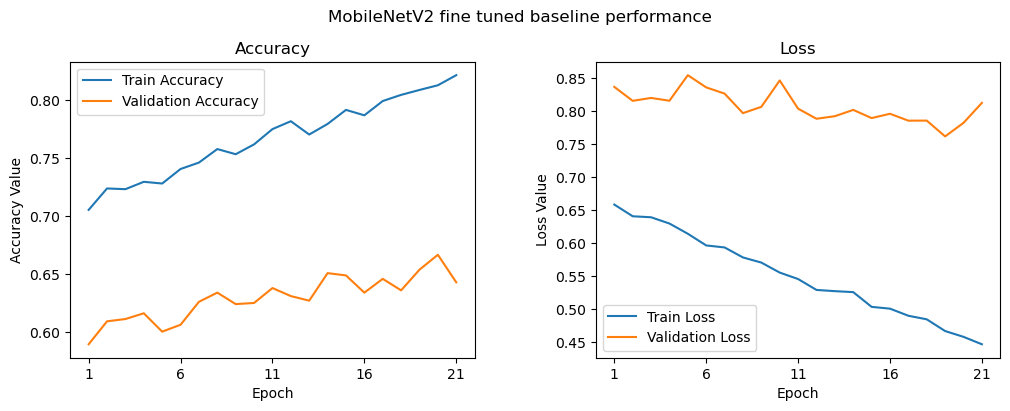

In [43]:
learning_performance_chart(title='MobileNetV2 fine tuned baseline performance', history=history_fine)

In [44]:
print('fine tuned MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

fine tuned MobileNetV2 performance on the test set:
32/32 [==============================] - 1s 17ms/step - loss: 0.8034 - accuracy: 0.6422


In [45]:
performance_df = record_performance(performance_df, 'MobileNetV2 fine tune top 56 layers', results[1])
performance_df

/tmp/ipykernel_28/3909242234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


,model,test set accuracy
0,MobileNetV2 base,0.537166
1,MobileNetV2 fine tune top 38 layers,0.603568
2,MobileNetV2 fine tune top 56 layers,0.642220


The last model showed the best results on the test set with accuracy at ~65%

# Prepare the submission

## Stage 1 test 

In [46]:
test_dir = os.path.join('../input/test/test')

test_files = glob.glob(test_dir+'/*.jpg')

print('Number of images in a test set:', len(test_files))

Number of images in a test set: 512


In [47]:
#sort test files in correct order for submission
from tkinter import Tcl
test_files = Tcl().call('lsort', '-dict', test_files)
test_files[:5]

('../input/test/test/0.jpg',
 '../input/test/test/1.jpg',
 '../input/test/test/2.jpg',
 '../input/test/test/3.jpg',
 '../input/test/test/4.jpg')

In [48]:
# Load images

features = []
bad_images = 0
    
for i in range(len(test_files)):
    try:
        img = cv2.imread(test_files[i])
        resized_img = cv2.resize(img, (160, 160))
            
        features.append(np.array(resized_img))
                   
    except Exception as e:
        bad_images+=1
        print('Encoutered bad image')
        
print('Bad images ecountered:', bad_images)
test_images = np.array(features)

Bad images ecountered: 0


In [49]:
test_images.shape

(512, 160, 160, 3)

In [50]:
predictions = model.predict(test_images)
predictions[:5]

16/16 [==============================] - 1s 14ms/step


array([[0.14806469, 0.82953805, 0.02239724],
       [0.08186127, 0.53668886, 0.38144988],
       [0.6471945 , 0.30858943, 0.04421612],
       [0.04801466, 0.8765945 , 0.07539085],
       [0.1389159 , 0.576027  , 0.28505713]], dtype=float32)

In [51]:
test_submissions = pd.DataFrame(
    {'image_name':test_files,
     'Type_1':predictions[:,0],
     'Type_2':predictions[:,1],
     'Type_3':predictions[:,2]})


test_submissions.to_csv('submission.csv', index = False)
test_submissions.head()

,image_name,Type_1,Type_2,Type_3
0,../input/test/test/0.jpg,0.148065,0.829538,0.022397
1,../input/test/test/1.jpg,0.081861,0.536689,0.381450
2,../input/test/test/2.jpg,0.647195,0.308589,0.044216
3,../input/test/test/3.jpg,0.048015,0.876594,0.075391
4,../input/test/test/4.jpg,0.138916,0.576027,0.285057
